# Plotting Point Clouds in different ways

Just try out some standard plots to see if there are some optimal or (in the very least) unusual representations of point cloud data that could be used as input to models.

Can we get some feeling for free-space by extracting points/features from the plots?

Could these plots be used as augmented data to increase the variance a model is exposed to by a single data set?

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy.spatial.distance import cdist
import numpy as np

# # Test data
# X = Y = np.linspace(0, 10, 100)
# Z = np.cos(X)

# Load numpy array of LiDAR data
data = np.load('./sample_lidar_data.npy')

print(data.shape)                      # (100, 4, 8)


(100, 4, 8)


The sample data is just a snapshot from an 8-channel point cloud, so the points are fairly sparse. The following images help to imagine what we are dealing with. We see that points reach about 10m metres away from the car in teh X and Y directions, with the road being roughtl 1m below the lidar mount point (negative Z-direction)

<img src="./8channel_lidar_point_cloud.JPG",width=600,height=600>

---------------------

In [2]:
# Helper function

def rescale(data, new_min=-1, new_max=1):
    """Rescale the columns of Dataframe or values of an array to be in the range [new_min, new_max].

    Parameters
    ----------
    data    : a Pandas DataFrame or a NumPy array
    new_min : the target minimum, optional
    new_max : the target maximum, optional

    Returns
    -------
    out : the rescaled input data, now in the range [new_min, new_max]

    """
    return (data - data.min()) / (data.max() - data.min()) * (new_max - new_min) + new_min


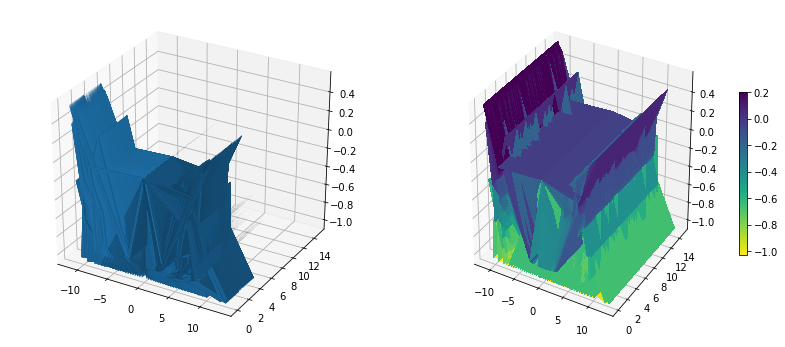

In [3]:
# Generate required axis points for 3D plots (matching dimensions of our data)

X = data[:, 0, :].reshape((800,))
Y = data[:, 1, :].reshape((800,))
Z = data[:, 2, :].reshape((800,))

Xm, Ym = np.meshgrid(X, Y)
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(Xm, Ym, Z, rstride=4, cstride=4, linewidth=0)

ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(Xm, Ym, Z, rstride=1, cstride=1,
                    cmap='viridis_r', linewidth=0, antialiased=False)

cb = fig.colorbar(p, shrink=0.5)

plt.show()


Ok, this does not actually look too promising. It does indicate the 'walls' at the sides, but otherwise just quite confusing!

--------------------------

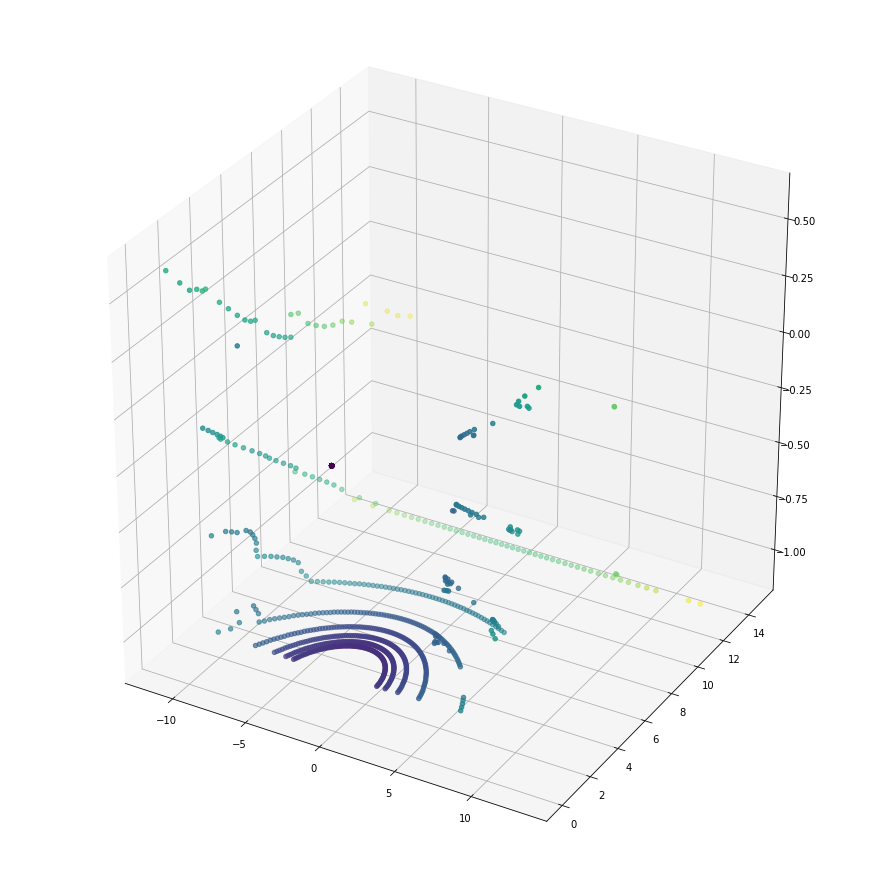

In [3]:
## ============================================ ##
##  Compute distance to each point from origin  ##
## ============================================ ##


# Reshape data into mat N rows and 3 columns: {x, y, z}
coords = data[:, 0:3, :]
samples = [angle.T for angle in coords]
points = np.vstack(samples)

# Define the origin, must be repeated to match dims of points for matmul
origin = np.zeros(points.shape)

# Compute distance to each points from origin
dists = cdist(points, origin)[:, 0]

# Rescale distances in range [0, 1]
scaled_distances = rescale(dists, 0, 1)

# Plot all points, with colour representing distance to origin.
fig = plt.figure(1, figsize=(12, 12))
fig.clf()
ax = Axes3D(fig)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=scaled_distances)
plt.gray()
plt.draw()
plt.show()


Adding colour to show distance to the lidar helps a human visualise things - might be nice for a dashboard of some kind. Could incorporate changes in distance over time, e.g. the relative velocity of the points within a voxel region.

-----------------------------------

<IPython.core.display.Javascript object>


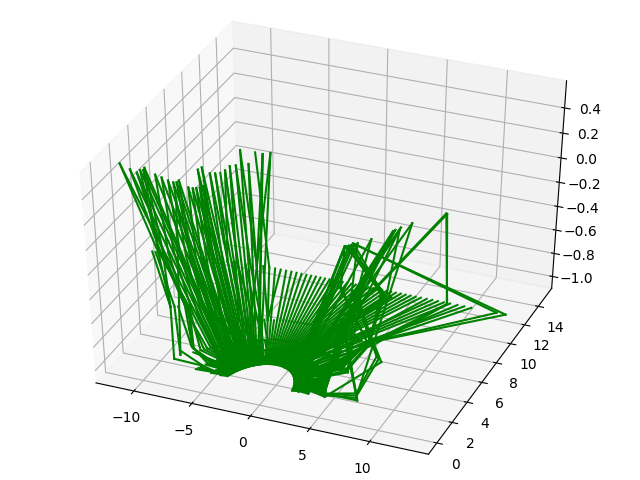

In [6]:

## ======================================== ##
##  Find the points closest to one another  ##
## ======================================== ##
%matplotlib notebook

# -------------------------------- #
#  Remove all points at (0, 0, 0)  #
# -------------------------------- #


zeros_points = points == np.array([0,0,0])
zero_mask = np.ma.masked_array(points, zeros_points)

all_dists = cdist(zero_mask, zero_mask)
zero_dists = all_dists == 0
masked_dists = np.ma.masked_array(all_dists, zero_dists)
neighbours = []

# Keep track of points already used
loop_mask = np.zeros_like(all_dists[0])

for i, dists in enumerate(masked_dists):
    # if np.sum(points[i]) == 0:
    #     continue
    mask = np.zeros_like(dists[1:])
    mask[(dists[1:] == 0.0) | (loop_mask[1:] > 0)] = True     # do mask any distances equal to zero
    masked_dists = np.ma.masked_array(dists[1:], mask)
    closest = np.argmin(masked_dists)
    if np.sum(points[closest]) == 0:
        continue
    pair = (points[i], points[closest])
    neighbours.append(pair)

    # To avoid getting the same pair backwards (duplicate), remove closest point
    loop_mask[closest] = 1


fig = plt.figure(1)
ax = Axes3D(fig)
for pair in neighbours:
    (x1, y1, z1), (x2, y2, z2) = pair
    ax.plot([x1, x2], [y1, y2], [z1, z2], 'g-')




plt.show()



This build a clearer view of where there is freespace - like a wire-plot around the freespace itself.
Perhaps something like this could be used to validate output from a trained model, or to enhance/augment training.

-----------------------

<IPython.core.display.Javascript object>


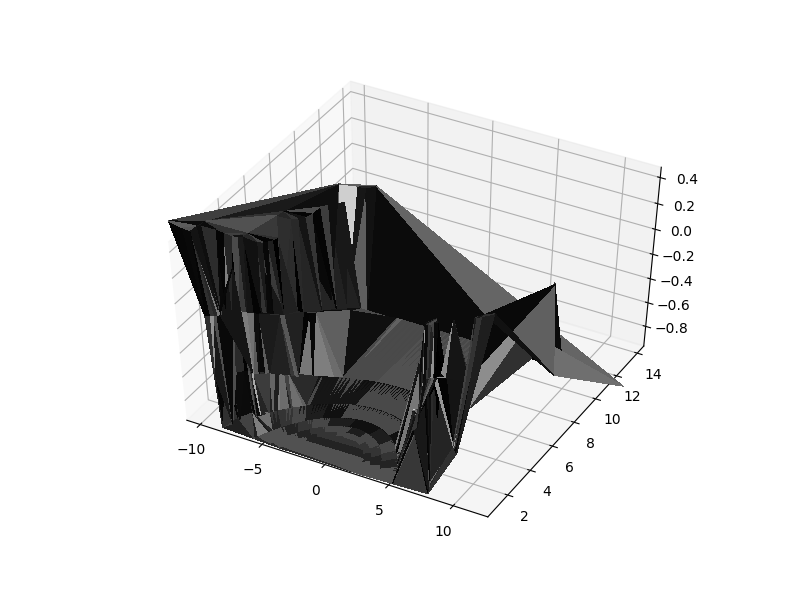

In [7]:

## ================================================================== ##
##  Try to use nearest neighbours to create mesh for 3d surface plot  ##
## ================================================================== ##

unpacked_neighbours = np.vstack(np.array(neighbours))
X, Y, Z = unpacked_neighbours[:,0], unpacked_neighbours[:,1], unpacked_neighbours[:,2]
# Define the origin, must be repeated to match dims of points for matmul
origin = np.zeros(unpacked_neighbours.shape)

# Compute distance to each points from origin
dists = cdist(unpacked_neighbours, origin)[:, 0]

# Rescale distances in range [0, 1]
scaled_distances = rescale(dists, 0, 1)
cs = [3*(v.astype(np.float32),) for v in scaled_distances]
cmap = plt.cm.Spectral.from_list(cs, cs)

Xm, Ym = np.meshgrid(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.gray()

p = ax.plot_trisurf(X, Y, Z, cmap=cmap, antialiased=False)

plt.show()


This is more intuitive that the wire-plot look above, as it really feels like we have some freespace map now defined. If the surface positions could be extracted, it might be a way to automatically label a denser point cloud semantically into 'freespace' and 'not freespace'. 

-----------------------------

<IPython.core.display.Javascript object>


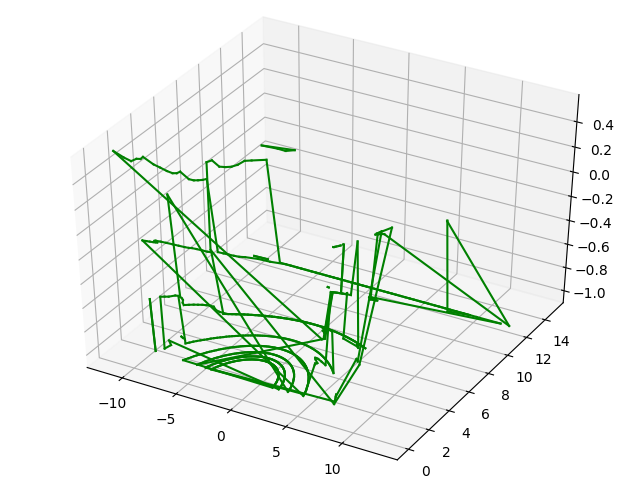

In [7]:

## ========================================== ##
##  Another approach to removing zero points  ##
## ========================================== ##
%matplotlib notebook

# remove any points that are at (0, 0, 0)
point_sums = np.sum(points, axis=1)
zero_points = np.where(point_sums == 0)[0]
slim_points = np.delete(points, zero_points, axis=0)
all_dists = cdist(slim_points, slim_points)
neighbours = []

loop_mask = np.zeros_like(all_dists[0])

for i, dists in enumerate(all_dists):
    mask = np.zeros_like(dists)
    mask[(dists == 0.0) | (loop_mask > 0)] = True     # do mask any distances equal to zero?
    masked_dists = np.ma.masked_array(dists, mask)
    closest = np.argmin(masked_dists)
    pair = (slim_points[i], slim_points[closest])
    neighbours.append(pair)

    # To avoid getting the same pair backwards (duplicate), remove closest point
    loop_mask[closest] = 1


fig = plt.figure(1)
ax = Axes3D(fig)
for pair in neighbours:
    (x1, y1, z1), (x2, y2, z2) = pair
    ax.plot([x1, x2], [y1, y2], [z1, z2], 'g-')

plt.show()
